# Exercise 1 - Smoothing and Interpolation

## Introduction
This exercise is about smoothing and interpolating medical images using B-spline basis functions. First, you will implement the principle on a one-dimensional signal, and then expand it to an image in 2D.

### Instructions for your report
Your report should be structured as follows:
* **Introduction**: a short summary of what your report is about, perhaps with a recap of some of the equations you'll be using in your solution.
* **Task 1, ..., 5**: for each specific task listed below, your code (in code cells), your results (as figures) as well as explanations of what is computed and what is shown in the figures (in Markdown cells). 
* **Conclusion**: a short summary of your findings.

This introduction should **not** be part of your report.

### Input data and code hints
Import Python libraries

In [1]:
import numpy as np
import nibabel as nib
from matplotlib import pyplot as plt

np.set_printoptions( suppress=True )
plt.style.use('dark_background') # Dark theme
plt.ion()

Read a 3D image (an MRI scan of the brain) and extract the 2D slice you'll be working with in this exercise:

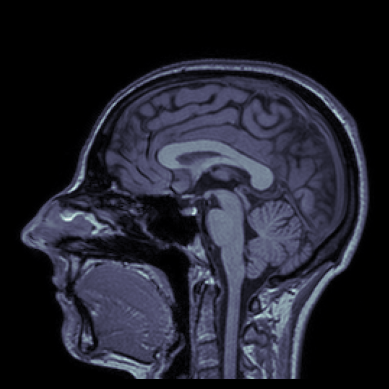

In [45]:
T1_file = './IXI002-Guys-0828-T1.nii.gz'
T1_nib = nib.load( T1_file )
data = T1_nib.get_fdata()

img = data[:, :, 75]
T = np.flipud( img.T )

plt.axis('off')
plt.imshow(T, cmap='bone');

Extract the 1D signal you'll be working with as the middle row of the 2D image

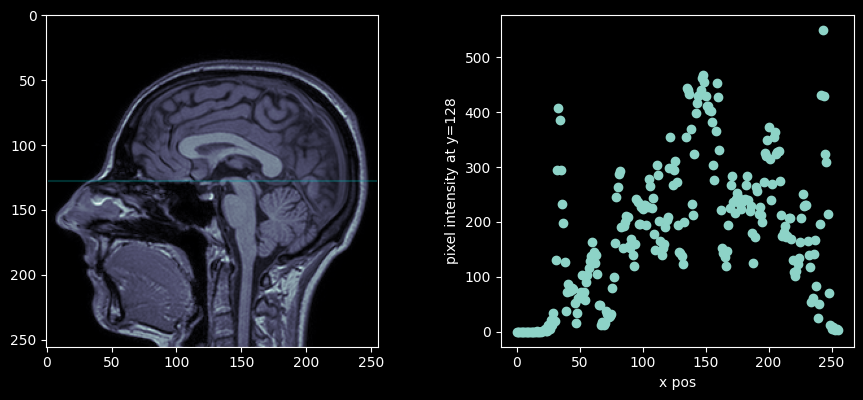

In [46]:
row = round( T.shape[0] / 2 )
t = T[row, :] #pixel intensity at row y = 128

N = t.shape[0]
x = np.arange(0, N)

# plot
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(10,5))
fig.tight_layout(pad=5.0)

ax[0].imshow(T, cmap='bone')
ax[0].hlines(row, xmin=1, xmax=255, alpha=0.25, color='c')

ax[1].scatter(x, t)
ax[1].set_xlabel('x pos')
ax[1].set_ylabel('pixel intensity at y={}'.format(row))

plt.show();

---
## Task 1: B-splines basis functions
Implement a function that evaluates the uniform B-spline of orders 0, 1 and 3 at the locations provided in a vector $\mathbf{x}$. 

The function should return a vector $\mathbf{y}$ that is the same length as $\mathbf{x}$:

    def eval_BSpline(x, order=0):

        """
        Evaluates the uniform B-spline of order "order" at the locations in vector "x"
        """

        ...

        return y


Use this function to plot the uniform B-spline of orders 0, 1 and 3 at locations:  $\mathbf{x} = [-3.0,-2.99,-2.98, \ldots, 2.99,3.0]$

> ***Hint:*** use the function ```np.arange()``` to obtain $\mathbf{x}$.

In [47]:
def eval_BSpline(x, order=0):
    """
    Evaluates the uniform B-spline of order "order" at the locations in vector "x"
    """

    x = np.asarray(x)  # Ensure x is a NumPy array
    y = np.zeros_like(x)

    # given the order evaluate the uniform B-spline at the locations in x
    if order == 0:
        y[(x > -0.5) & (x < 0.5)] = 1
        y[(x == -0.5) | (x == 0.5)] = 0.5
        y[(x < -0.5) | (x > 0.5)] = 0
        # for i in range(len(x)):
        #     if x[i] > -0.5 and x[i] < 0.5:
        #         y[i] = 1
        #     elif x[i] == -0.5 or x[i] == 0.5:
        #         y[i] = 0.5
        #     else:
        #         y[i] = 0
    elif order == 1:
        y[(x >= -1) & (x < 0)] = x[(x >= -1) & (x < 0)] + 1
        y[(x >= 0) & (x <= 1)] = 1 - x[(x >= 0) & (x <= 1)]
        y[(x < -1) | (x > 1)] = 0
        # for i in range(len(x)):
        #     if x[i] > -1 and x[i] < 0:
        #         y[i] = x[i] + 1
        #     elif x[i] >= 0 and x[i] <= 1:
        #         y[i] = 1 - x[i]
        #     else:
        #         y[i] = 0
    elif order == 3:
        abs_x = np.abs(x)
        
        # Different cases for cubic B-spline
        y[abs_x < 1] = (4 - 6 * abs_x[abs_x < 1]**2 + 3 * abs_x[abs_x < 1]**3) / 6.0
        y[(abs_x >= 1) & (abs_x < 2)] = (2 - abs_x[(abs_x >= 1) & (abs_x < 2)])**3 / 6.0
        y[abs_x >= 2] = 0
    else:
        raise ValueError('Order not implemented')

    return y

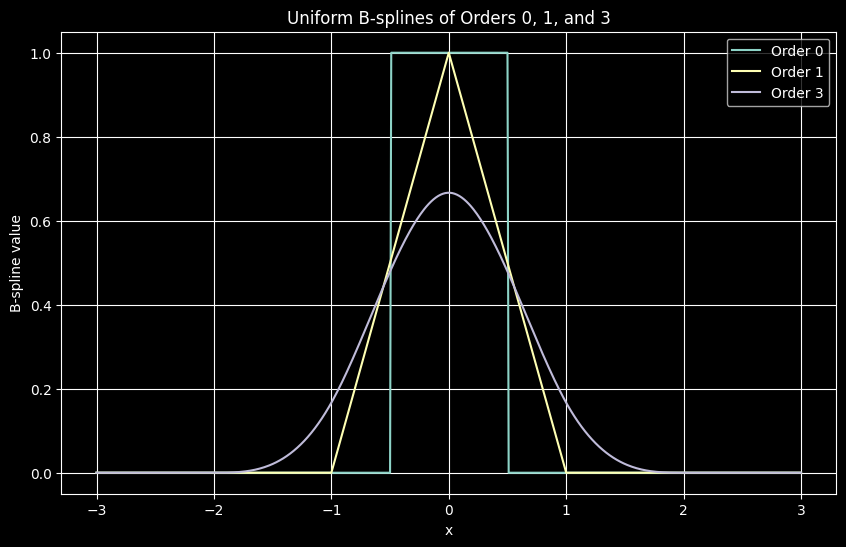

In [19]:
# Let's generate the axis
x = np.arange(-3.0, 3.01, 0.01)

# Generate a random verctor of length len(x) with integers from 0 to 3
v = np.random.randint(0, 50, len(x))

# Evaluate and plot the B-splines for orders 0, 1, and 3
plt.figure(figsize=(10, 6))

for order in [0, 1, 3]:
    y = eval_BSpline(x, order)
    plt.plot(x, y, label=f'Order {order}')

plt.title('Uniform B-splines of Orders 0, 1, and 3')
plt.xlabel('x')
plt.ylabel('B-spline value')
plt.legend()
plt.grid(True)
plt.show()

As we can see in the result the B-spline are fixed functions, in this case centered in zero that are pulse functions which get smoother based on the order, the order 0 is a 

---
## Task 2: Smoothing
Using the function you wrote above for evaluating a uniform B-spline of order 3, generate $M=6$ basis functions covering the entire domain $x=0,1,\ldots, 255$ of the 1D signal $\mathbf{t}$ defined in the introduction (which has length $N=256$). 

The basis functions should be scaled by a factor $h=(N-1)/(M-1)$, and shifted to be $h$ units apart (see book). 

Collect the obtained basis functions in a $N \times M$ matrix $\boldsymbol{\Phi}$, and plot them.

51.0


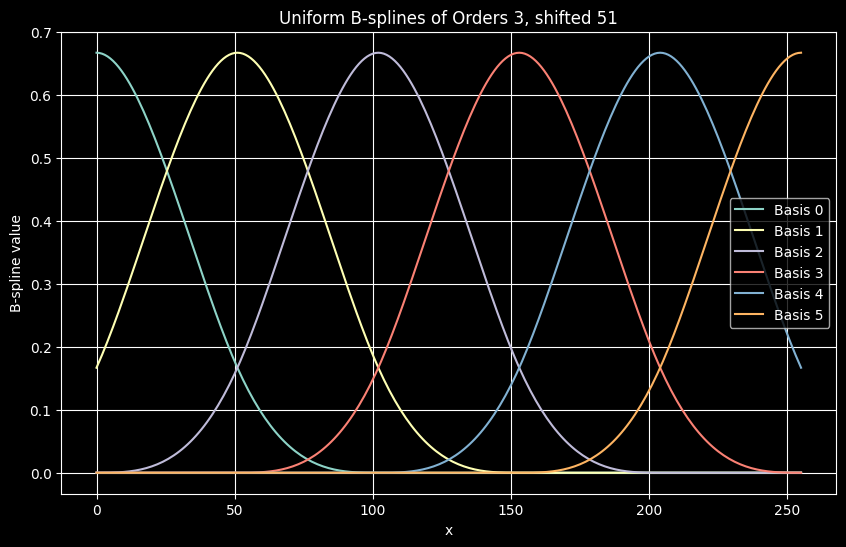

In [48]:
N = 256
M = 6
h = (N - 1) / ( M - 1 )
print(h)

# create an empty array of length 6
phi = np.zeros((N, M))

x = np.arange(N)

plt.figure(figsize=(10, 6))

for i in range(M):
    center = i * h
    shifted = (x - center) / h
    y = eval_BSpline(shifted, 3)
    phi[:, i] = y
    plt.plot(x, y, label=f'Basis {i}')

plt.title('Uniform B-splines of Orders 3, shifted 51')
plt.xlabel('x')
plt.ylabel('B-spline value')
plt.legend()
plt.grid(True)
plt.show()


Compute:
- the smoothing matrix: $\mathbf{S} = \boldsymbol{\Phi} (\boldsymbol{\Phi}^T \boldsymbol{\Phi})^{-1} \boldsymbol{\Phi}^T$
- the smoothed signal:  $\mathbf{\hat{t}} = \mathbf{S} \mathbf{t}$

Plots the results. Also plot the middle row of the smoothing matrix. 

>***Hint:*** 
>
> To compute the solution of a linear equation of the form Ax = b, you can use the following numpy function: ```np.linalg.solve(A, b)```. 
>
> You can also use the matrix inversion function ```np.linalg.inv()```, although this is numerically not the best solution.

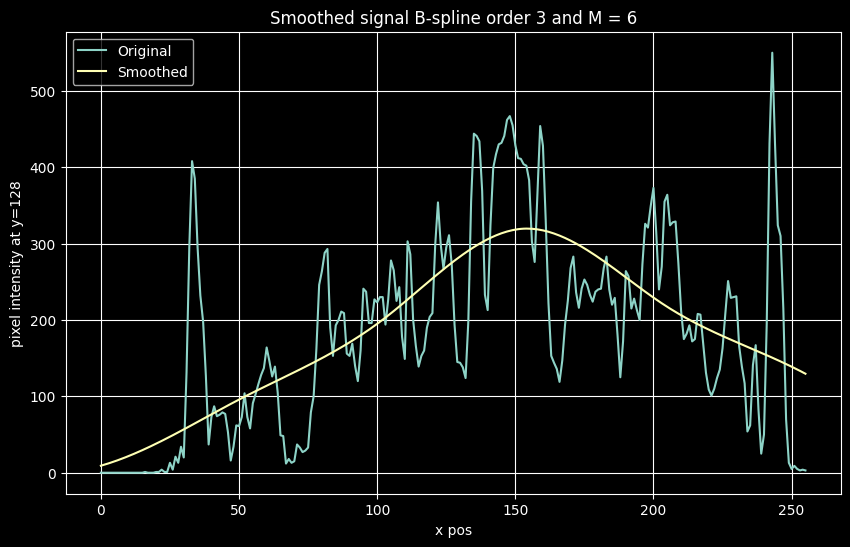

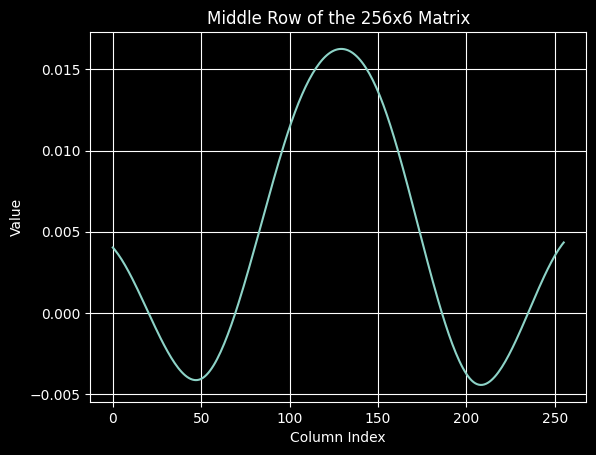

In [49]:
# compute the smoothing matrix
S = phi @ np.linalg.pinv(phi.T @ phi) @ phi.T

# apply the smoothing matrix to the image
T_smoothed = S @ t

# plot
plt.figure(figsize=(10, 6))
plt.title('Smoothed signal B-spline order 3 and M = 6')
plt.plot(x, t, label='Original')
plt.plot(x, T_smoothed, label='Smoothed')
plt.xlabel('x pos')
plt.ylabel('pixel intensity at y={}'.format(row))
plt.legend()
plt.grid(True)
plt.show()


middle_row_index = N // 2
middle_row = S[middle_row_index, :]

# Plot the middle row
plt.plot(middle_row)
plt.title(f'Middle Row of the {N}x{M} Matrix')
plt.xlabel('Column Index')
plt.ylabel('Value')
plt.grid(True)
plt.show()

Now repeat the same experiment when more basis functions are used: $M=16$ and $M=52$. 

> ***Q?:*** How does the smoothing behavior change? Explain.

17.0


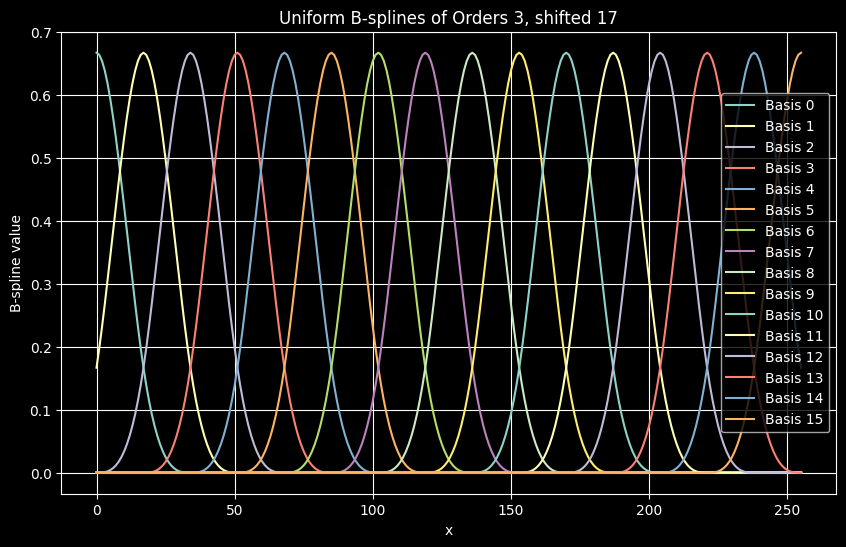

In [50]:
# M = 16
N = 256
M = 16
h = (N - 1) / ( M - 1 )
print(h)

# create an empty array of length 6
phi = np.zeros((N, M))

x = np.arange(N)

plt.figure(figsize=(10, 6))

for i in range(M):
    center = i * h
    shifted = (x - center) / h
    y = eval_BSpline(shifted, 3)
    phi[:, i] = y
    plt.plot(x, y, label=f'Basis {i}')

plt.title('Uniform B-splines of Orders 3, shifted 17')
plt.xlabel('x')
plt.ylabel('B-spline value')
plt.legend()
plt.grid(True)
plt.show()

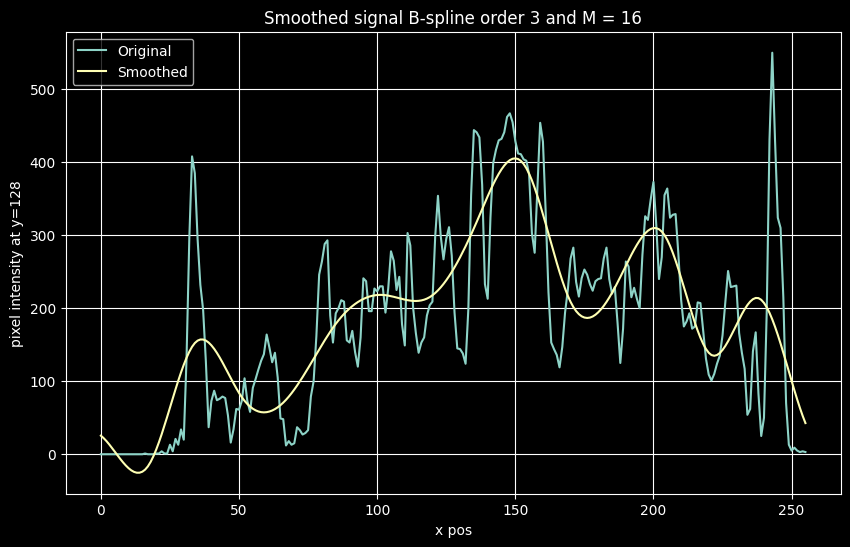

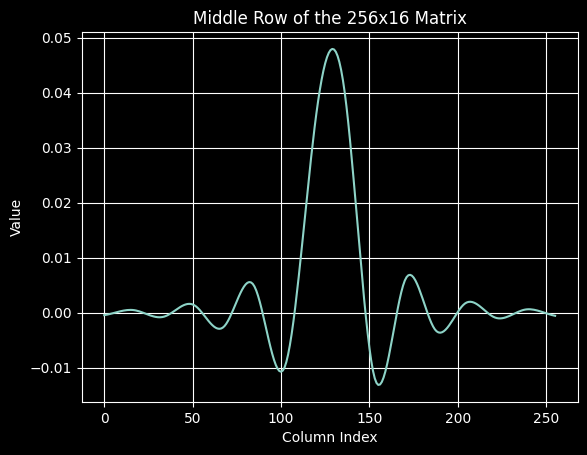

In [51]:
# compute the smoothing matrix
S = phi @ np.linalg.pinv(phi.T @ phi) @ phi.T

# apply the smoothing matrix to the image
T_smoothed = S @ t

# plot
plt.figure(figsize=(10, 6))
plt.title('Smoothed signal B-spline order 3 and M = 16')
plt.plot(x, t, label='Original')
plt.plot(x, T_smoothed, label='Smoothed')
plt.xlabel('x pos')
plt.ylabel('pixel intensity at y={}'.format(row))
plt.legend()
plt.grid(True)
plt.show()

middle_row_index = N // 2
middle_row = S[middle_row_index, :]

# Plot the middle row
plt.plot(middle_row)
plt.title(f'Middle Row of the {N}x{M} Matrix')
plt.xlabel('Column Index')
plt.ylabel('Value')
plt.grid(True)
plt.show()

5.0


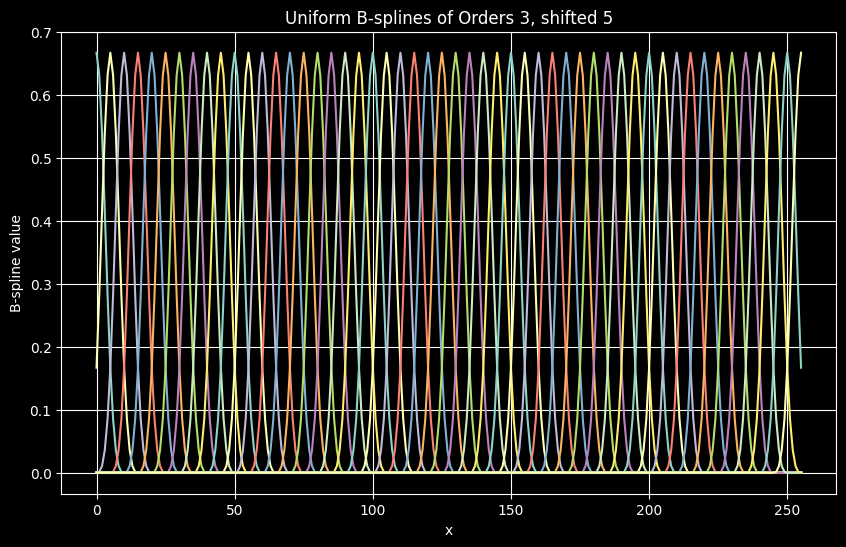

In [52]:
# M = 52
N = 256
M = 52
h = (N - 1) / ( M - 1 )
print(h)

# create an empty array of length 6
phi = np.zeros((N, M))

x = np.arange(N)

plt.figure(figsize=(10, 6))

for i in range(M):
    center = i * h
    shifted = (x - center) / h
    y = eval_BSpline(shifted, 3)
    phi[:, i] = y
    plt.plot(x, y, label=f'Basis {i}')

plt.title('Uniform B-splines of Orders 3, shifted 5')
plt.xlabel('x')
plt.ylabel('B-spline value')
plt.grid(True)
plt.show()

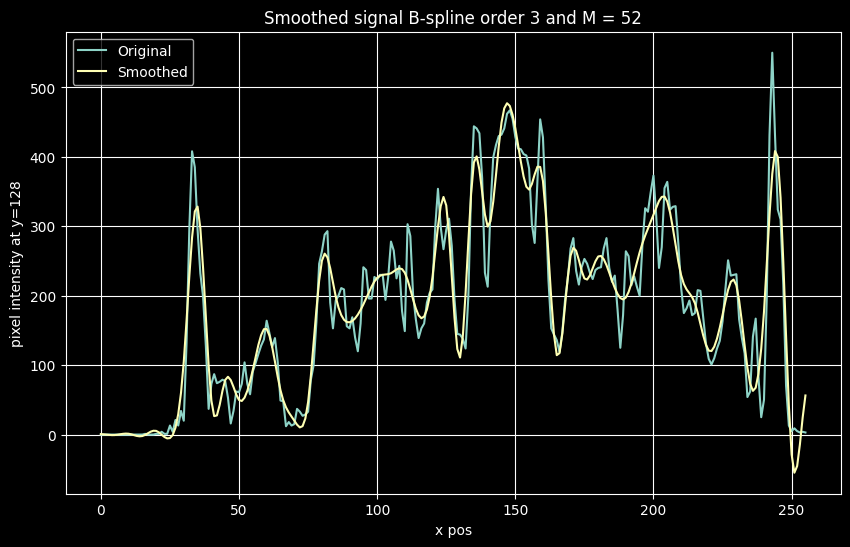

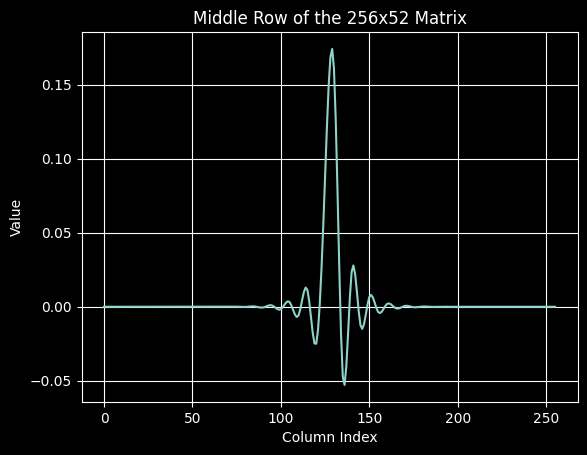

In [53]:
S = phi @ np.linalg.pinv(phi.T @ phi) @ phi.T

# apply the smoothing matrix to the image
T_smoothed = S @ t

# plot
plt.figure(figsize=(10, 6))
plt.title('Smoothed signal B-spline order 3 and M = 52')
plt.plot(x, t, label='Original')
plt.plot(x, T_smoothed, label='Smoothed')
plt.xlabel('x pos')
plt.ylabel('pixel intensity at y={}'.format(row))
plt.legend()
plt.grid(True)
plt.show()

middle_row_index = N // 2
middle_row = S[middle_row_index, :]

# Plot the middle row
plt.plot(middle_row)
plt.title(f'Middle Row of the {N}x{M} Matrix')
plt.xlabel('Column Index')
plt.ylabel('Value')
plt.grid(True)
plt.show()

---
## Task 3: Interpolation
Implement B-spline interpolation of the 1D signal $\mathbf{t}$, by evaluating the function $y( x, \mathbf{w})$ at locations $x = [120, 120.01, 120.02, \ldots 140]$

Show your results, along with the corresponding part of the signal $\mathbf{t}$, for three different orders of B-splines: 0, 1 and 3.

In [54]:
print(t)

# transform t into a column vector
t_1D = t[:, np.newaxis]
print(t)

[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   1.   0.   0.   0.   1.   1.   4.   1.   1.  13.   4.  21.
  13.  34.  20. 131. 295. 408. 385. 295. 232. 198. 127.  37.  73.  87.
  74.  76.  79.  77.  53.  16.  34.  62.  61.  73. 104.  73.  58.  91.
 103. 116. 128. 137. 164. 146. 126. 139. 105.  49.  48.  12.  18.  13.
  15.  37.  33.  27.  29.  33.  79. 100. 162. 246. 264. 288. 293. 190.
 153. 193. 200. 211. 209. 156. 153. 169. 140. 120. 160. 241. 237. 196.
 196. 227. 223. 230. 230. 194. 227. 278. 265. 225. 243. 178. 149. 303.
 286. 201. 166. 139. 153. 160. 190. 204. 209. 298. 354. 299. 267. 295.
 311. 272. 194. 145. 144. 138. 124. 199. 355. 444. 441. 434. 369. 233.
 213. 324. 399. 417. 430. 432. 441. 462. 467. 455. 429. 412. 411. 404.
 402. 383. 303. 276. 366. 454. 428. 331. 222. 153. 144. 136. 119. 147.
 194. 225. 268. 283. 236. 216. 241. 253. 246. 233. 224. 237. 240. 241.
 268. 283. 240. 220. 229. 180. 125. 172. 264. 257. 215. 228. 213. 200.
 273. 

/var/folders/v6/q9xwr1gn2dvdngsx947dpj280000gn/T/ipykernel_7305/1374626800.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_interp[i] = np.dot(weights, local_t)
/var/folders/v6/q9xwr1gn2dvdngsx947dpj280000gn/T/ipykernel_7305/1374626800.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_interp[i] = np.dot(weights, local_t)


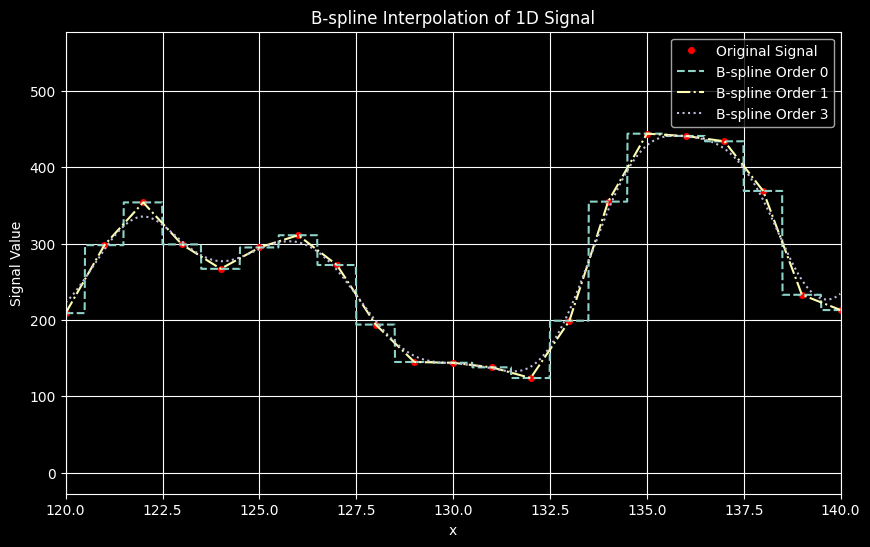

In [60]:
# implemente B-spline interpolation of signal t at locations x
x = np.arange(120, 140, 0.01)
x_t = np.arange(len(t))

def interpolate_signal(t_signal, x_signal, x_interp, order):
    y_interp = np.zeros_like(x_interp)
    
    # Handle order 0 separately (it only needs the nearest two points)
    if order == 0:
        for i, xi in enumerate(x_interp):
            idx = np.searchsorted(x_signal, xi) - 1
            if idx < 0 or idx >= len(x_signal) - 1:
                continue
            
            # Local coordinates for nearest two points
            local_x = x_signal[idx:idx + 2] - xi
            local_t = t_signal[idx:idx + 2]
            
            # Use eval_BSpline for order 0
            weights = eval_BSpline(local_x, order=order)
            y_interp[i] = np.dot(weights, local_t)
    
    # For orders 1 and 3, use neighborhood of size `order + 1`
    else:
        neighborhood_size = order + 1
        for i, xi in enumerate(x_interp):
            idx = np.searchsorted(x_signal, xi) - 1
            if idx < (neighborhood_size - 1) // 2 or idx >= len(x_signal) - (neighborhood_size // 2):
                continue

            # Define the local neighborhood of points
            local_indices = np.arange(idx - (neighborhood_size // 2), idx + (neighborhood_size // 2) + 1)
            local_x = x_signal[local_indices] - xi
            local_t = t_signal[local_indices]

            # Use eval_BSpline for higher orders
            weights = eval_BSpline(local_x, order=order)
            y_interp[i] = np.dot(weights, local_t)
    
    return y_interp


# Interpolate for B-spline orders 0, 1, and 3
y_interp_order0 = interpolate_signal(t_1D, x_t, x, order=0)
y_interp_order1 = interpolate_signal(t_1D, x_t, x, order=1)
y_interp_order3 = interpolate_signal(t_1D, x_t, x, order=3)

# Plot the original signal and the interpolated signals
plt.figure(figsize=(10, 6))

# plot original signal
# plt.plot(x_t[(x_t >= 120) & (x_t <= 140)], 
#          t[(x_t >= 120) & (x_t <= 140)], 
#          label='Original Signal (120 to 140)', color='red', linewidth=1.5)

# Plot original signal
plt.plot(x_t, t_1D, label='Original Signal', color='red', linestyle='None', marker='o', markersize=4)

# Plot interpolated signals for different B-spline orders
plt.plot(x, y_interp_order0, label='B-spline Order 0', linestyle='--')
plt.plot(x, y_interp_order1, label='B-spline Order 1', linestyle='-.')
plt.plot(x, y_interp_order3, label='B-spline Order 3', linestyle=':')

# Set the x-axis limits to 120 and 140
plt.xlim(120, 140)

# Labels and legends
plt.title('B-spline Interpolation of 1D Signal')
plt.xlabel('x')
plt.ylabel('Signal Value')
plt.legend()
plt.grid(True)
plt.show()


---
## Task 4: Smoothing in 2D
Now you are going to smooth the 2D image $\mathbf{T}$, which has dimensions $N_1 \times N_2 = 256 \times 256$, with $M_1=M_2=5$ B-spline-based 1D basis functions of order 3 for each direction.

Use the Kronecker product to produce a $N \times M$ matrix $\boldsymbol{\Phi} = \boldsymbol{\Phi}_2 \otimes \boldsymbol{\Phi}_1$, where:
- $N=N_1 N_2$ 
- $M = M_1 M_2$. 

Show a few 2D basis functions contained in the columns of $\boldsymbol{\Phi}$.

>***Hints***:
>* the Kronecker product of two matrices A and B can be calculated with ```np.kron(A, B)```
>* for converting a vectorized basis function ```v``` back into its 2D shape, use ```v.reshape(N_1, N_2, order='F')```
>* the following snippet can be used to show a 2D basis function:
>    ```
>        plt.figure(); 
>        ax = plt.axes(projection='3d'); 
>        ax.plot_wireframe(np.arange(N1).reshape(-1, 1), np.arange(N2).reshape(1, -1), basisFunction)
>
>    ```

(5, 256)
(5, 256)
(1280, 1280)


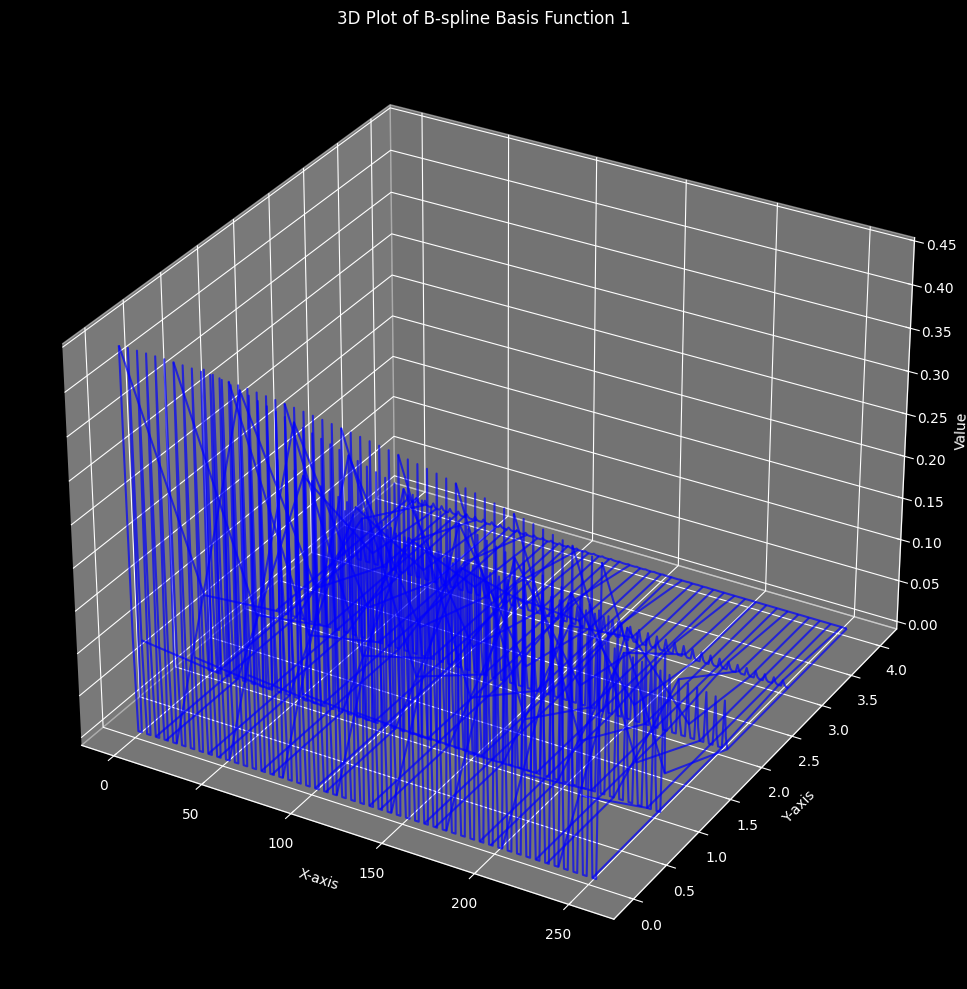

In [72]:
N_dim = 256
M_dim = 5

# N = np.zeros((N_dim, N_dim))
# M = np.zeros((M_dim, M_dim))

def b_spline_basis_1d(order, num_basis, num_points):
    x = np.linspace(0, num_basis - order, num_points)
    return np.array([eval_BSpline(x - i, order) for i in range(num_basis)])

# Evaluate basis functions for each direction
phi1 = b_spline_basis_1d(order, M_dim, N_dim)
phi2 = b_spline_basis_1d(order, M_dim, N_dim)

print(phi1.shape)
print(phi2.shape)

# Kronecker product to form the 2D basis functions
Phi = np.kron(phi2.T, phi1)  # (N1*N2) x (M1*M2)
print(Phi.shape)

assert Phi.shape == (M_dim * N_dim, M_dim * N_dim), f"Unexpected shape: {Phi.shape}"


# Plot a few selected 2D basis functions in 3D
num_to_plot = 1  # Number of basis functions to plot
fig = plt.figure(figsize=(15, 10))

for i in range(num_to_plot):
    ax = plt.axes(projection='3d')

    # Get the basis function at index i and reshape it to (N_dim, M_dim)
    basis_function = Phi[:, i].reshape(N_dim, M_dim, order='F')  # Should be (N_dim, N_dim) based on hint but does not work

    # Create a meshgrid for plotting
    X, Y = np.meshgrid(np.arange(N_dim), np.arange(M_dim))

    # Correct the plot dimensions
    ax.plot_wireframe(X, Y, basis_function.T, color='blue', alpha=0.7)

    ax.set_title(f'3D Plot of B-spline Basis Function {i + 1}')
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_zlabel('Value')


plt.tight_layout()
plt.show()

Now:
- vectorize the 2D image $\mathbf{T}$ into a 1D signal $\mathbf{t}$
- smooth using $\boldsymbol{\Phi}$
- re-arrange the resulting 1D signal $\mathbf{\hat{t}}$ back into a 2D image $\mathbf{\hat{T}}$
- show the result.

>***Hints***: 
>* use ```T.reshape(-1, 1, order='F')``` and ```t.reshape(N_1, N_2, order='F')``` to vectorize and undo the vectorization.
>* do not explicitly compute the smoothing matrix $\mathbf{S}$ as it is very large!! Instead compute the weights $\mathbf{w} = (\boldsymbol{\Phi}^T \boldsymbol{\Phi})^{-1} \boldsymbol{\Phi}^T \mathbf{t}$ and expand those to get $\mathbf{\hat{t}} = \boldsymbol{\Phi} \mathbf{w}$.


Also perform the same smoothing operation by exploiting the separability of the 2D basis functions, i.e, perform row-wise and then column-wise smoothing instead. 

Show the results, and verify that they are identical (use ```np.allclose()```) 

---
## Task 5: Interpolation in 2D
For B-spline order 0, 1 and 3, compute the weights $\mathbf{W}$ of the 2D interpolation model fitted to $\mathbf{T}$ by exploiting the separability of its basis functions.

Then show, as an image, interpolated function values $y( \mathbf{x}, \mathbf{w})$ for $\mathbf{x}=(x_1, x_2)^T$ with:
- $x_1=120.0, 120.1, 120.2 \ldots, 130.0$ 
- $x_2=120.0, 120.1, 120.2 \ldots, 130.0$ 